In [1]:
%tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import os
import scipy.io
import tarfile
from PIL import Image
from tqdm import tqdm_notebook
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


In [2]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

--2020-01-07 18:01:55--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘102flowers.tgz.1’

102flowers.tgz.1    100%[===================>] 328.89M  10.1MB/s    in 34s     

2020-01-07 18:02:30 (9.69 MB/s) - ‘102flowers.tgz.1’ saved [344862509/344862509]



In [4]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102segmentations.tgz

--2020-01-07 18:02:33--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102segmentations.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203577493 (194M) [application/x-gzip]
Saving to: ‘102segmentations.tgz.1’

102segmentations.tg 100%[===================>] 194.15M  9.92MB/s    in 21s     

2020-01-07 18:02:55 (9.34 MB/s) - ‘102segmentations.tgz.1’ saved [203577493/203577493]



In [5]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

--2020-01-07 18:02:59--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502
Saving to: ‘imagelabels.mat.1’

imagelabels.mat.1   100%[===================>]     502  --.-KB/s    in 0s      

2020-01-07 18:02:59 (88.9 MB/s) - ‘imagelabels.mat.1’ saved [502/502]



In [0]:
labels = scipy.io.loadmat('imagelabels.mat')
labels = np.array(labels['labels'][0])

In [0]:
imageFile  = tarfile.open(name='102flowers.tgz', mode='r:gz')
savepath = '/tmp/102flowers/'
imageFile.extractall(savepath)
segmentfile = tarfile.open(name= '102segmentations.tgz', mode='r:gz')
savepath_seg = '/tmp/102flowers_seg/'
segmentfile.extractall(savepath_seg)

In [0]:
train_path = '/tmp/train/'
test_path = '/tmp/test/'
if not os.path.isdir(train_path):
  os.mkdir(train_path)
if not os.path.isdir(test_path):
  os.mkdir(test_path)

In [6]:
np.random.seed(42)
count_M20 = 0
for i in range(101):
    rand = np.random.randint(0, 100, dtype= np.int64)
    if rand > 20:
        count_M20 += 1
print(count_M20, '%')

78 %


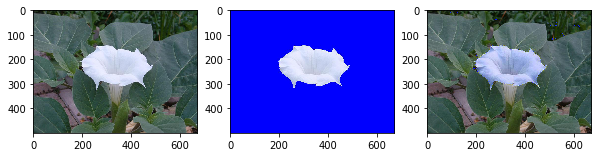

In [7]:
path = savepath + 'jpg/'
path_seg = savepath_seg + 'segmim/'
for f in tqdm_notebook(os.listdir(path), total= len(os.listdir(path))):
  image = Image.open(os.path.join(path, f))
  image_id = int(f.replace('image_', "").replace('.jpg',""))
  seg_image = Image.open(os.path.join(path_seg, f.replace('image', 'segmim')))
  img_np = np.array(image)
  seg_np = np.array(seg_image)
  sum_img = np.add(img_np, seg_np)
  fig = plt.figure(figsize=(10,10))
  ax1 = fig.add_subplot(1,3,1)
  ax1.imshow(image)
  ax1 = fig.add_subplot(1,3,2)
  ax1.imshow(seg_image)
  ax1 = fig.add_subplot(1,3,3)
  ax1.imshow(sum_img)
  break

In [8]:
path = savepath + 'jpg/'
path_seg = savepath_seg + 'segmim/'
for f in tqdm_notebook(os.listdir(path), total= len(os.listdir(path))):
  image = Image.open(os.path.join(path, f))
  image_id = int(f.replace('image_', "").replace('.jpg',""))
  rand = np.random.randint(0,100,dtype= np.int64)
  if rand > 20:
    if not os.path.isdir(train_path + str(labels[image_id-1])):
        os.mkdir(train_path + str(labels[image_id-1]))
    seg_np = np.array(Image.open(os.path.join(path_seg, f.replace('image', 'segmim'))))
    image_np = np.array(image)
    sum_np = np.add(image_np, seg_np)
    (Image.fromarray(sum_np)).save(train_path + str(labels[image_id-1]) + '/' + f )
  else:
    if not os.path.isdir(test_path + str(labels[image_id-1])):
        os.mkdir(test_path + str(labels[image_id-1]))
    image.save(test_path + str(labels[image_id-1]) + '/' + f )

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TARGET_SIZE = (128,128)  

data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     rescale = 1/255.,
                     horizontal_flip = True,
                     vertical_flip = True,
                     validation_split=0.22,
                     fill_mode = 'nearest')


train_datagen = ImageDataGenerator(**data_gen_args)
#train_datagen = ImageDataGenerator(validation_split=0.22,width_shift_range=0.1,zoom_range=0.2, rescale= 1/255.)

train_generator = train_datagen.flow_from_directory(train_path, subset='training', target_size = TARGET_SIZE, batch_size = 32, class_mode = 'categorical', seed=42, shuffle=True)

valid_generator = train_datagen.flow_from_directory(train_path, subset='validation', target_size = TARGET_SIZE, batch_size = 32, class_mode = 'categorical', seed=42, shuffle=True)

#train_generator = train_datagen.flow(imgs, y_one_hot, batch_size=128, subset='training', seed=42)

test_datagen = ImageDataGenerator(rescale= 1/255.)

test_generator = test_datagen.flow_from_directory(test_path, target_size= TARGET_SIZE, batch_size = 32, class_mode = 'categorical', seed = 42, shuffle=True)

Found 6153 images belonging to 102 classes.
Found 1673 images belonging to 102 classes.
Found 3144 images belonging to 102 classes.


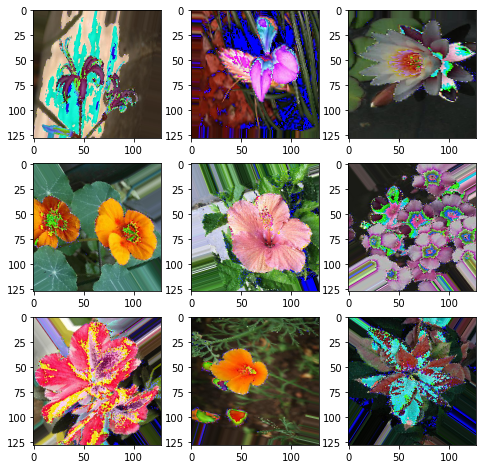

In [10]:
sample = train_generator.next()
fig = plt.figure(figsize=(8,8))
for idx in range(9):
    ax = fig.add_subplot(3, 3, idx+1)
    img = sample[0][idx]
    ax.imshow(img)
plt.show()

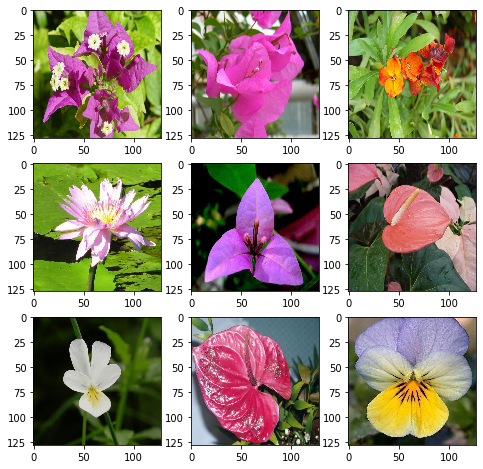

In [11]:
test = test_generator.next()
fig = plt.figure(figsize=(8,8))
for idx in range(9):
    ax = fig.add_subplot(3, 3, idx+1)
    img = test[0][idx]
    ax.imshow(img)
plt.show()

In [0]:
IMG_WIDTH, IMG_HEIGHT = TARGET_SIZE
CHANNELS = 3
eps = 1.1e-5
concat_axis = 3
savefile = 'densenet_flower_class_mark05.h5'

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Layer, InputSpec
try:
    from tensorflow.keras import initializations
except ImportError:
    from tensorflow.keras import initializers as initializations

class Scale(Layer):
    '''Custom Layer for DenseNet used for BatchNormalization.
    
    Learns a set of weights and biases used for scaling the input data.
    the output consists simply in an element-wise multiplication of the input
    and a sum of a set of constants:
        out = in * gamma + beta,
    where 'gamma' and 'beta' are the weights and biases learnt.
    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).
        momentum: momentum in the computation of the
            exponential average of the mean and standard deviation
            of the data, for feature-wise normalization.
        weights: Initialization weights.
            List of 2 Numpy arrays, with shapes:
            `[(input_shape,), (input_shape,)]`
        beta_init: name of initialization function for shift parameter
            (see [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        gamma_init: name of initialization function for scale parameter (see
            [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
    '''
    def __init__(self, weights=None, axis=-1, momentum = 0.9, beta_init='zero', gamma_init='one', **kwargs):
        self.momentum = momentum
        self.axis = axis
        self.beta_init = initializations.get(beta_init)
        self.gamma_init = initializations.get(gamma_init)
        self.initial_weights = weights
        super(Scale, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (int(input_shape[self.axis]),)

        self.gamma = tf.Variable(self.gamma_init(shape), name='{}_gamma'.format(self.name))
        self.beta = tf.Variable(self.beta_init(shape), name='{}_beta'.format(self.name))
        #self.trainable_weights = [self.gamma, self.beta]

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis]

        out = tf.reshape(self.gamma, broadcast_shape) * x + tf.reshape(self.beta, broadcast_shape)
        return out

    def get_config(self):
        config = {"momentum": self.momentum, "axis": self.axis}
        base_config = super(Scale, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def conv_block(x, stage, branch, nb_filter, dropout_rate = None, weight_decay = 1e-4):
  conv_name_base = 'conv' + str(stage) + '_' + str(branch)
  relu_name_base = 'relu' + str(stage) + '_' + str(branch)
  #1X1 convolution
  inter_channel = nb_filter * 4
  x = BatchNormalization(epsilon=eps, axis=concat_axis, name = conv_name_base + '_x1_bn')(x)
  x = Scale(axis=concat_axis, name=conv_name_base + '_x1_scale')(x)
  x = Activation('relu', name= relu_name_base + '_x1')(x)
  x = Conv2D(inter_channel, (1,1), name=conv_name_base + '_x1', use_bias=False)(x)
  
  if dropout_rate:
    x = Dropout(dropout_rate)(x)

  #3X3 convolution
  x = BatchNormalization(epsilon=eps, axis= concat_axis, name=conv_name_base + '_x2_bn')(x)
  x = Scale(axis= concat_axis, name = conv_name_base + '_x2_scale')(x)
  x = Activation('relu', name= relu_name_base + '_x2')(x)
  x = ZeroPadding2D((1,1), name= conv_name_base + '_x2_zeropadding')(x)
  x = Conv2D(nb_filter, (3,3), name=conv_name_base + '_x2', use_bias=False)(x)

  if dropout_rate:
    x = Dropout(dropout_rate)(x)
  
  return x

def transition_block(x, stage, nb_filter, compression= 1.0, dropout_rate = None, weight_decay = 1e-4):
  conv_name_base = 'conv' + str(stage) + '_blk'
  relu_name_base = 'relu' + str(stage) + '_blk'
  pool_name_base = 'pool' + str(stage)
  x = BatchNormalization(epsilon=eps, axis = concat_axis, name=conv_name_base + '_bn')(x)
  x = Scale(axis=concat_axis, name=conv_name_base+'_scale')(x)
  x = Activation('relu', name= relu_name_base)(x)
  x = Conv2D(int(nb_filter * compression), (1,1), name= conv_name_base, use_bias=False)(x)
  if dropout_rate:
    x = Dropout(dropout_rate)(x)
  x = AveragePooling2D((2,2), strides=(2,2), name = pool_name_base)(x)
  return x

def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay= 1e-4, grow_nb_filters= True):
  concat_feat = x
  for i in range(nb_layers):
    branch = i + 1
    x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
    concat_feat = concatenate([concat_feat, x], axis=concat_axis, name = 'concat_'+str(stage)+'_'+str(branch))

    if grow_nb_filters:
      nb_filter += growth_rate
  return concat_feat, nb_filter

def DenseNet(nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.0, dropout_rate=0.5, weight_decay=1e-4, classes=1000, weights_path=None):
  compression = 1.0 - reduction
  nb_layers = [2,3,6,4] # [6,12,24,16]
  #input layer
  img_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS), name='data')
  #initial convolution
  x = ZeroPadding2D((3,3), name='conv1_zeropadding')(img_input)
  x = Conv2D(nb_filter, (7,7), strides=(2,2), name = 'conv1', use_bias=False )(x)
  x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
  x = Scale(axis= concat_axis, name='conv1_scale')(x)
  x = Activation(activation='relu', name= 'relu1')(x)
  x = ZeroPadding2D((1,1), name='pool1_zeropadding')(x)
  x = MaxPool2D((3,3), strides=(2,2), name= 'pool1')(x)

  #Adding dense blocks
  for i in range(nb_dense_block - 1):
    stage = i + 2
    x, nb_filter = dense_block(x, stage, nb_layers[i], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

    #transition block
    x = transition_block(x, stage, nb_filter, compression=compression, dropout_rate=dropout_rate, weight_decay=weight_decay)
    nb_filter = int(nb_filter * compression)
  final_stage = stage + 1
  x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate,  weight_decay=weight_decay)
  x = BatchNormalization(epsilon=eps, axis = concat_axis, name='conv'+str(final_stage)+'_blk_bn')(x)
  x = Scale(axis=concat_axis, name='conv'+str(final_stage)+'_blk_scale')(x)
  x = Activation('relu', name = 'relu' + str(final_stage) +'_blk' )(x)
  x = GlobalAveragePooling2D(name='pool' + str(final_stage) +'_blk')(x)
  x = Dense(classes, name='fc6')(x)
  x = Activation('softmax', name='prob')(x)
  model = Model(img_input, x, name='densenet')
  if weights_path is not None:
    model.load_weight(weights_path)
  model.summary()
  return model

In [0]:
if os.path.isfile(savefile):
  weights_path = savefile
else:
  weight_path = None

In [15]:
DenseNetModel = DenseNet(classes=102, weights_path=weight_path, reduction=0.05)

Model: "densenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, 134, 134, 3)  0           data[0][0]                       
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9408        conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
DenseNetModel.compile(optimizer= tf.optimizers.Adam(0.001), loss='categorical_crossentropy', 
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy')>.95):
            print("\nReached 95% accuracy!")
            self.model.stop_training = True

myCallback = mycallback()

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1), myCallback,
             tf.keras.callbacks.ModelCheckpoint(savefile, verbose=1, save_best_only=True, save_weights_only=True),
             tf.keras.callbacks.CSVLogger(savefile.replace('.h5', '_log.csv'), append=True, separator=','),
             ReduceLROnPlateau( factor=0.1, patience=5, min_lr=0.00001, verbose=1)]

In [17]:
%tensorboard --logdir logs/fit

<IPython.core.display.Javascript object>

In [0]:
!rm -r logs/fit

In [19]:
history = DenseNetModel.fit_generator(train_generator, steps_per_epoch=(train_generator.samples//train_generator.batch_size), validation_data=valid_generator,validation_steps=valid_generator.samples//valid_generator.batch_size , callbacks=callbacks, verbose=1, epochs=200)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 192 steps, validate for 52 steps
Epoch 1/200
191/192 [============================>.] - ETA: 0s - loss: 4.4269 - accuracy: 0.0645 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 00001: val_loss improved from inf to 4.59362, saving model to densenet_flower_class_mark05.h5
192/192 [==============================] - 76s 393ms/step - loss: 4.4256 - accuracy: 0.0645 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 4.5936 - val_accuracy: 0.0210 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
191/192 [============================>.] - ETA: 0s - loss: 4.1220 - accuracy: 0.0938 - precision: 0.6154 - recall: 0.0013
Epoch 00002: val_loss did not improve from 4.59362
192/192 [==============================] - 65s 340ms/step - loss: 4.1216 - accuracy: 0.0938 - precision: 0.6154 - recall: 0.0013 - val_loss: 4.6485 - val_accuracy: 0.0156 -

In [0]:
DenseNetModel.load_weights(savefile)

In [0]:
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = DenseNetModel.predict_generator(test_generator,steps = nb_samples)

In [0]:
DenseNetModel.evaluate_generator(test_generator,steps = nb_samples)

In [0]:
plt.figure(figsize=(15,8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_precision'], label='val_precision')
plt.plot(history.history['val_recall'], label='val_recall')
plt.xlabel('Epoch')
plt.legend()

In [0]:
tf.keras.utils.plot_model(DenseNetModel, 
                          to_file= 'model.png',
                          show_shapes= True,
                          show_layer_names= True,
                          rankdir= 'TB',
                          expand_nested= True,
                          dpi= 96)

In [0]:
DenseNetModel.evaluate_generator(test_generator2,steps = nb_samples)

In [0]:
plt.plot(history.history['recall'], history.history['precision'])
plt.xlabel('recall')
plt.ylabel('precision')

In [0]:
predict2 = DenseNetModel.predict_generator(test_generator2,steps = nb_samples)

In [0]:
plt.imshow(test_generator2.next()[0][0])
tf.argmax(test_generator2.next()[1][0]).numpy()

In [0]:
STEP_SIZE_TEST=test_generator2.n//test_generator2.batch_size+1
test_generator2.reset()
pred=DenseNetModel.predict_generator(test_generator2,
steps=STEP_SIZE_TEST,
verbose=1)

In [0]:
DenseNetModel.evaluate_generator(test_generator2,steps = STEP_SIZE_TEST, verbose=1)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
test_generator2.reset()

lab_pred = DenseNetModel.predict_generator(test_generator2, 1757 // 16 +1, verbose=1)
lab_pred = np.argmax(lab_pred, axis=1)
print('confusion matrix testset')
print(confusion_matrix(test_generator2.classes, lab_pred))


In [0]:
target_names = ['class {}'.format(i) for i in range(1,103)]
print('calssification report testset')
print(classification_report(test_generator2.classes, lab_pred, target_names=target_names))

In [0]:
target_names2 = ['class {}'.format(i) for i in range(1,103)]
valid_pred = DenseNetModel.predict_generator(valid_generator, 1361 // 16 +1, verbose=1)
valid_pred = np.argmax(valid_pred, axis=1)
print('confusion matrix validation set')
print(confusion_matrix(valid_generator.classes, valid_pred))
print('calssification report validatoin set')
print(classification_report(valid_generator.classes, valid_pred, target_names=target_names2))